In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
from scipy.integrate import ode 
from numpy import log10 as lg
from numpy import pi as pi
from numpy import sin as sin
from numpy import cos as cos
from numpy import tan as tan
from scipy.interpolate import interp1d as sp_interp1d
from astropy import constants as const
from astropy import units as u
import math
from math import radians as radian
from numpy import linalg as LA
from scipy.special import ellipj
from numpy import e as e
import scipy.integrate as integrate
from scipy.optimize import fsolve
from scipy.integrate import quad, dblquad
from scipy.interpolate import splev, splrep
'''customize the plot '''
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.labelpad'] = 8.0
plt.rcParams['figure.constrained_layout.h_pad'] = 0
plt.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1
plt.close()

G=const.G.cgs.value
c=const.c.cgs.value
Ms=const.M_sun.cgs.value
hbar=const.hbar.cgs.value
kb=const.k_B.cgs.value
m_n=const.m_n.cgs.value
km=10**5
yr=(1.0*u.yr).cgs.value
e=const.e.esu.value
me=const.m_e.cgs.value
mp=const.m_p.cgs.value

# Ray tracing function 

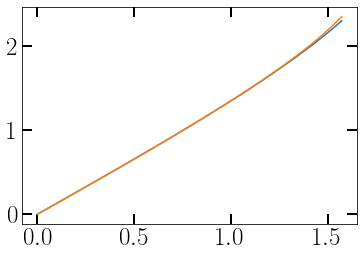

In [2]:
def raytracing(theta_em):
    
    x=sin(theta_em)
    M=1.4*Ms
    R=10*km
    Rs=2*G*M/c**2
    ratio=Rs/R
    def integrand(u):
        return x * ((1-ratio)*(ratio/2)**2 -(1-2*u) * u**2 * x**2 ) ** (-0.5)
    sol=quad(integrand, 0, 0.5*ratio)
    return sol[0]

def raytracing1(theta_em):
    
    M=1.4*Ms
    R=10*km
    Rs=2*G*M/c**2
    ratio=Rs/R
    sol=np.arccos((cos(theta_em)-ratio)/(1-ratio))
    return sol

# we use the raytracing function in Beloborodov 2002

theta=np.linspace(0,pi/2,100)
s1=np.zeros(theta.size)
s2=np.zeros(theta.size)
for i in range(len(theta)):
    s1[i]=raytracing(theta[i])
    s2[i]=raytracing1(theta[i])
    
plt.plot(theta,s1)
plt.plot(theta,s2)

# Inverse function

In [4]:
xx1=np.linspace(0,pi/2,2000)
yy1=np.zeros(xx1.size)
for i in range(xx1.size):
    yy1[i]=raytracing(xx1[i])
    
th2te=sp_interp1d(yy1, xx1,fill_value=(0, pi/2),bounds_error=False)

In [5]:
th2te(10)

array(1.57079633)

# Hotspot emission 

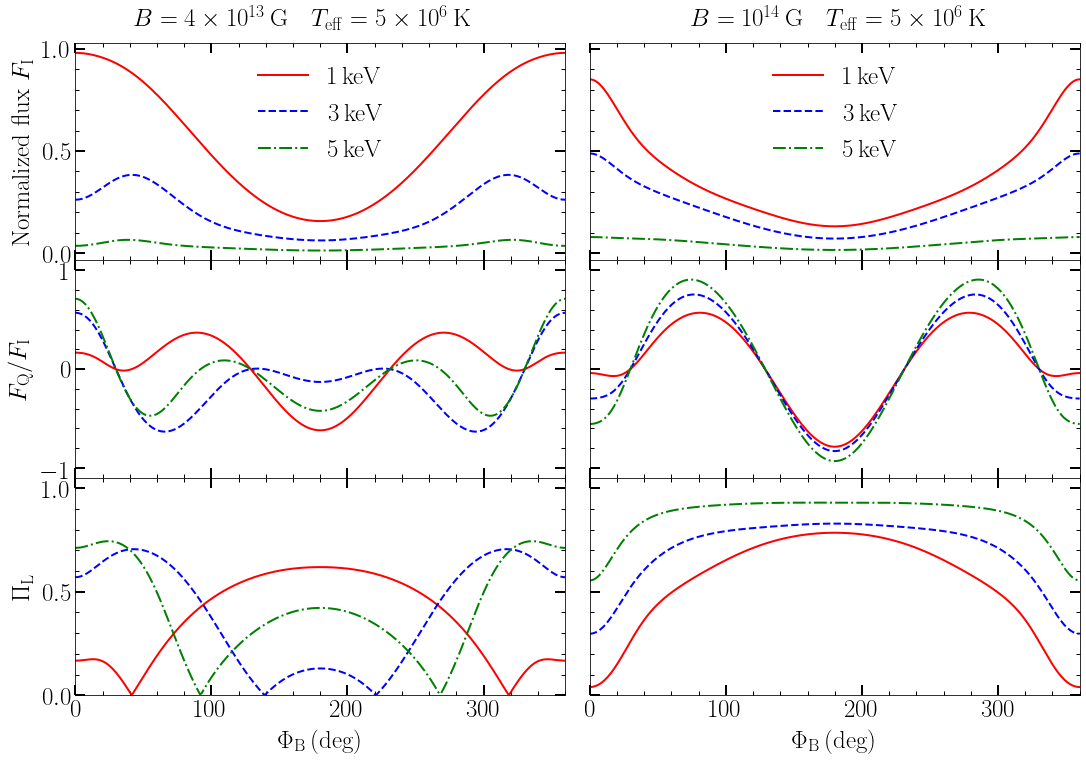

In [74]:
def T2t(T):
    
    ratio=2*G*1.4*Ms/c**2 /km /10
    
    return np.arccos(ratio + (1-ratio)*cos(T))

name=['B4131kev','B4133kev','B4135kev']
colors=['red','blue','green']
line=['solid','dashed','dashdot']
label=[r'$1\,\rm keV$',r'$3\,\rm keV$',r'$5\,\rm keV$']

fig,axs =plt.subplots(3,2, figsize=(18,12), gridspec_kw={'height_ratios': [1, 1,1]},sharex=True,sharey='row')
plt.subplots_adjust(hspace=0.0)
plt.subplots_adjust(wspace=0.05)

for j in range(len(name)):
    data=np.genfromtxt('./'+name[j]+'.dat')
    
    theta_em=data[:,0]
    Ix=data[:,1]
    Io=data[:,2]
    
    Xmode=sp_interp1d(theta_em, Ix,fill_value=(0, 0),bounds_error=False)
    Omode=sp_interp1d(theta_em, Io,fill_value=(0, 0),bounds_error=False)
    
    alpha=radian(65)
    i=radian(45)
    P=2
    omega=2*pi/P
    t=np.linspace(0,2,300)
    Phi=omega*t
    cosTheta=cos(i)*cos(alpha)+sin(i)*sin(alpha)*cos(Phi)
    Theta=np.arccos(cosTheta)
    theta=th2te(Theta)
    Ix1=np.zeros(theta.size)
    Io1=np.zeros(theta.size)
    
    for i in range(len(theta)):
        Ix1[i]=Xmode(theta[i])*cos(theta[i])
        Io1[i]=Omode(theta[i])*cos(theta[i])
        
    Psi=np.arctan2(sin(alpha)*sin(Phi), (-sin(i)*cos(alpha)+cos(i)*sin(alpha)*cos(Phi)))
    
    FI=(Ix1+Io1)
    
    normal=13140.452575491554
    
    FQ=(Io1-Ix1)*cos(2*Psi)
    
    FU=(Io1-Ix1)*sin(2*Psi)
    
    PL=(FQ**2+FU**2)**0.5/FI
    
    axs[0,0].plot(Phi/pi*180,FI/normal,linewidth=2,color=colors[j],linestyle=line[j],label=label[j])
    axs[1,0].plot(Phi/pi*180,FQ/FI,linewidth=2,color=colors[j],linestyle=line[j])
    axs[2,0].plot(Phi/pi*180,(FQ**2+FU**2)**(0.5)/FI,linewidth=2,color=colors[j],linestyle=line[j])
    axs[0,0].set_xlim(0,360)

axs[0,0].legend(fontsize=25,frameon=False,ncol=1)
axs[0,0].set_ylabel(r'${\rm Normalized\ flux}\ F_{\rm I}$',fontsize=25)
axs[1,0].set_ylabel(r'$ F_{\rm Q}/F_{\rm I}$',fontsize=25)
axs[2,0].set_ylabel(r'$ \Pi_{\rm L}$',fontsize=25)
axs[2,0].set_xlabel(r'$\Phi_{\rm B}\,(\rm deg)$',fontsize=25)

name1=['B142kev','B143kev','B145kev']



for j in range(len(name1)):
    data=np.genfromtxt('./'+name1[j]+'.dat')
    
    theta_em=data[:,0]
    Ix=data[:,1]
    Io=data[:,2]
    
    Xmode=sp_interp1d(theta_em, Ix,fill_value=(Ix[0], 0),bounds_error=False)
    Omode=sp_interp1d(theta_em, Io,fill_value=(Io[0], 0),bounds_error=False)
    
    alpha=radian(65)
    i=radian(45)
    P=2
    omega=2*pi/P
    t=np.linspace(0,2,300)
    Phi=omega*t
    cosTheta=cos(i)*cos(alpha)+sin(i)*sin(alpha)*cos(Phi)
    Theta=np.arccos(cosTheta)
    theta=th2te(Theta)
    Ix1=np.zeros(theta.size)
    Io1=np.zeros(theta.size)
    
    for i in range(len(theta)):
        Ix1[i]=Xmode(theta[i])*cos(theta[i])
        Io1[i]=Omode(theta[i])*cos(theta[i])
        
    Psi=np.arctan2(sin(alpha)*sin(Phi), (-sin(i)*cos(alpha)+cos(i)*sin(alpha)*cos(Phi)))
    
    FI=(Ix1+Io1)
    normal1=23897.392014859506
    
    FQ=(Io1-Ix1)*cos(2*Psi)
    
    FU=(Io1-Ix1)*sin(2*Psi)
    
    PL=(FQ**2+FU**2)**0.5/FI
    
    axs[0,1].plot(Phi/pi*180,FI/normal1,linewidth=2,color=colors[j],linestyle=line[j],label=label[j])
    axs[1,1].plot(Phi/pi*180,FQ/FI,linewidth=2,color=colors[j],linestyle=line[j])
    axs[2,1].plot(Phi/pi*180,(FQ**2+FU**2)**(0.5)/FI,linewidth=2,color=colors[j],linestyle=line[j])
axs[0,1].legend(fontsize=25,frameon=False,ncol=1)
axs[0,1].set_xlim(0,360)
axs[0,1].minorticks_on()
axs[1,1].set_ylim(-1.1,1.1)
axs[1,1].minorticks_on()
axs[2,1].set_ylim(0,1.05)
axs[2,1].minorticks_on()
axs[2,1].set_xlabel(r'$\Phi_{\rm B}\,(\rm deg)$',fontsize=25) 
fig.text(0.17, 0.9, r'$B=4\times 10^{13}\,{\rm G}\quad T_{\rm eff}=5\times 10^{6}\,\rm K$' ,fontsize=25) 
fig.text(0.60, 0.9, r'$B=10^{14}\,{\rm G}\quad T_{\rm eff}=5\times 10^{6}\,\rm K$' ,fontsize=25)

plt.savefig("../../paper/fig_stokes1.pdf", format='pdf', bbox_inches="tight")

20330.50231849603
11662.43468974855
1897.2163769787358


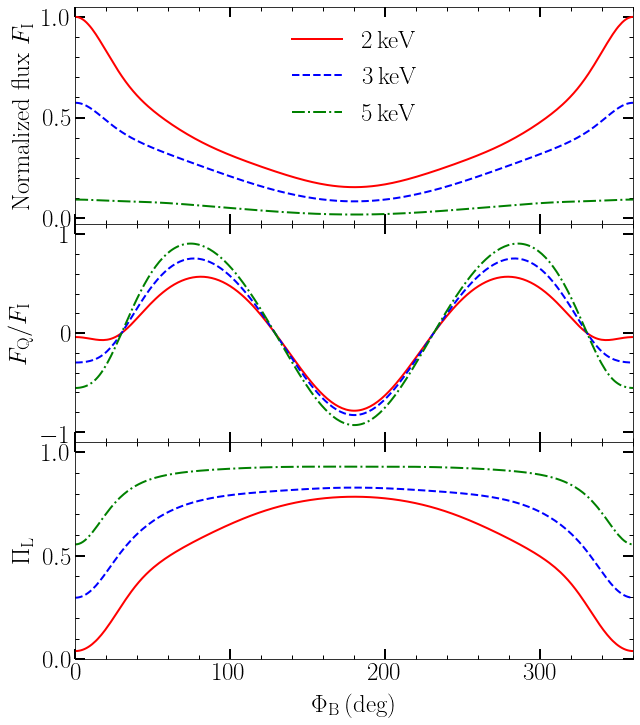

In [204]:
def T2t(T):
    
    ratio=2*G*1.4*Ms/c**2 /km /10
    
    return np.arccos(ratio + (1-ratio)*cos(T))

name=['B4131kev','B4133kev','B4135kev']
colors=['red','blue','green']
line=['solid','dashed','dashdot']
label=[r'$2\,\rm keV$',r'$3\,\rm keV$',r'$5\,\rm keV$']

fig,axs =plt.subplots(3,1, figsize=(10,12), gridspec_kw={'height_ratios': [1, 1,1]},sharex=True,sharey='row')
plt.subplots_adjust(hspace=0.0)




name1=['B142kev','B143kev','B145kev']



for j in range(len(name1)):
    data=np.genfromtxt('./'+name1[j]+'.dat')
    
    theta_em=data[:,0]
    Ix=data[:,1]
    Io=data[:,2]
    
    Xmode=sp_interp1d(theta_em, Ix,fill_value=(Ix[0], 0),bounds_error=False)
    Omode=sp_interp1d(theta_em, Io,fill_value=(Io[0], 0),bounds_error=False)
    
    alpha=radian(65)
    i=radian(45)
    P=2
    omega=2*pi/P
    t=np.linspace(0,2,300)
    Phi=omega*t
    cosTheta=cos(i)*cos(alpha)+sin(i)*sin(alpha)*cos(Phi)
    Theta=np.arccos(cosTheta)
    theta=th2te(Theta)
    Ix1=np.zeros(theta.size)
    Io1=np.zeros(theta.size)
    
    for i in range(len(theta)):
        Ix1[i]=Xmode(theta[i])*cos(theta[i])
        Io1[i]=Omode(theta[i])*cos(theta[i])
        
    Psi=np.arctan2(sin(alpha)*sin(Phi), (-sin(i)*cos(alpha)+cos(i)*sin(alpha)*cos(Phi)))
    
    FI=(Ix1+Io1)
    
    print(max(FI))

    
    normal1=20330.50231849603
    
    FQ=(Io1-Ix1)*cos(2*Psi)
    
    FU=(Io1-Ix1)*sin(2*Psi)
    
    PL=(FQ**2+FU**2)**0.5/FI
    
    axs[0].plot(Phi/pi*180,FI/normal1,linewidth=2,color=colors[j],linestyle=line[j],label=label[j])
    axs[1].plot(Phi/pi*180,FQ/FI,linewidth=2,color=colors[j],linestyle=line[j])
    axs[2].plot(Phi/pi*180,(FQ**2+FU**2)**(0.5)/FI,linewidth=2,color=colors[j],linestyle=line[j])

axs[0].legend(fontsize=25,frameon=False,ncol=1)
axs[0].set_ylabel(r'${\rm Normalized\ flux}\ F_{\rm I}$',fontsize=25)
axs[1].set_ylabel(r'$ F_{\rm Q}/F_{\rm I}$',fontsize=25)
axs[2].set_ylabel(r'$ \Pi_{\rm L}$',fontsize=25)
axs[2].set_xlabel(r'$\Phi_{\rm B}\,(\rm deg)$',fontsize=25)
axs[0].set_xlim(0,360)
axs[0].minorticks_on()
axs[1].set_ylim(-1.1,1.1)
axs[1].minorticks_on()
axs[2].set_ylim(0,1.05)
axs[2].minorticks_on()
axs[2].set_xlabel(r'$\Phi_{\rm B}\,(\rm deg)$',fontsize=25) 
# fig.text(0.17, 0.9, r'$B=4\times 10^{13}\,{\rm G}\quad T_{\rm eff}=5\times 10^{6}\,\rm K$' ,fontsize=25) 
# fig.text(0.60, 0.9, r'$B=10^{14}\,{\rm G}\quad T_{\rm eff}=5\times 10^{6}\,\rm K$' ,fontsize=25)

plt.savefig("../../paper/fig_stokes1.pdf", format='pdf', bbox_inches="tight")

In [206]:
theta/pi*180

array([15.28492639, 15.30295407, 15.35690485, 15.44638786, 15.57076634,
       15.72917911, 15.9205679 , 16.14370865, 16.39724562, 16.67972488,
       16.98962784, 17.32540035, 17.68547944, 18.068316  , 18.47239321,
       18.89624051, 19.33844467, 19.79765739, 20.27259947, 20.76206388,
       21.26491557, 21.78009164, 22.30659817, 22.84350863, 23.3899598 ,
       23.9451489 , 24.5083288 , 25.07880627, 25.6559353 , 26.23911661,
       26.82779219, 27.42144242, 28.01958284, 28.62176256, 29.22755962,
       29.83657938, 30.44845284, 31.06283382, 31.67939599, 32.29783417,
       32.91785969, 33.53919973, 34.16159622, 34.78480545, 35.40859548,
       36.03274568, 36.65704584, 37.2812952 , 37.90530134, 38.52888027,
       39.15185555, 39.77405719, 40.39532136, 41.01548991, 41.63440842,
       42.25192995, 42.86791073, 43.4822097 , 44.09469095, 44.70522245,
       45.31367217, 45.91991558, 46.5238257 , 47.12528216, 47.72416497,
       48.32035406, 48.91373493, 49.50419271, 50.09161406, 50.67

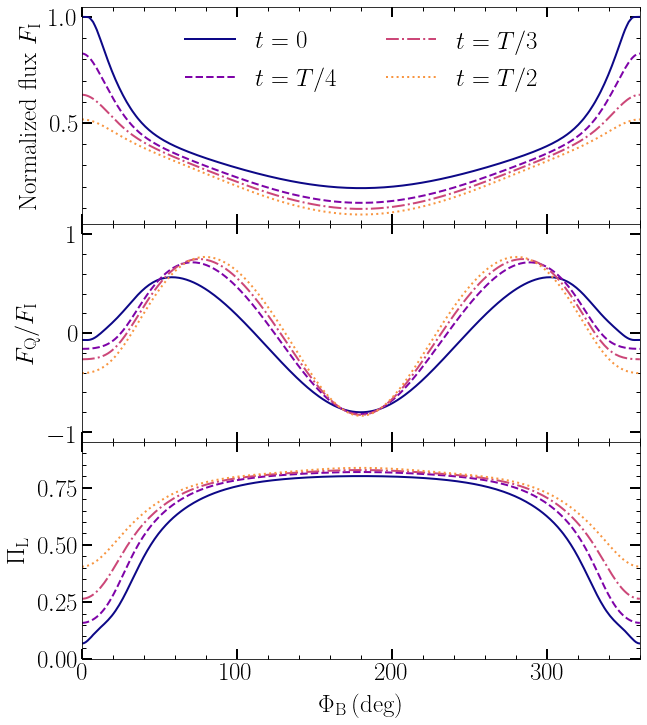

In [5]:
# def T2t(T):
    
#     ratio=2*G*1.4*Ms/c**2 /km /10
    
#     return np.arccos(ratio + (1-ratio)*cos(T))
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter

def magnetic_inclination(t, theta, T, P, chi):

    psi=-2*pi/T*t+pi/2
    return np.arccos(np.sin(theta)*np.sin(psi)*np.sin(chi)+np.cos(theta)*np.cos(chi))

epsilon=5e-7
P=2
chi=55/180*pi
theta=15/180*pi
T=P/epsilon/np.cos(theta)
t=np.array([0,T/4,T/3,T/2])
alpha1=np.zeros(len(t))   
for i in range(len(t)):
    alpha1[i]=magnetic_inclination(t[i],theta,T,P,chi)

name=['B4131kev','B4133kev','B4135kev']
colors=['red','blue','green']
line=['solid','dashed','dashdot','dotted']
label=[r'$t=0$',r'$t=T/4$',r'$t=T/3$',r'$t=T/2$']


p=plt.get_cmap('plasma')
fig,axs =plt.subplots(3,1, figsize=(10,12), gridspec_kw={'height_ratios': [1, 1,1]},sharex=True,sharey='row')
plt.subplots_adjust(hspace=0.0)


for j in range(len(alpha1)):
    data=np.genfromtxt('./B143kev.dat')
    
    theta_em=data[:,0]
    Ix=data[:,1]
    Io=data[:,2]
    
    Xmode=sp_interp1d(theta_em, Ix,fill_value=(Ix[0], 0),bounds_error=False)
    Omode=sp_interp1d(theta_em, Io,fill_value=(Io[0], 0),bounds_error=False)
    
    alpha=alpha1[j]
    i=radian(45)
    P=2
    omega=2*pi/P
    t=np.linspace(0,2,300)
    Phi=omega*t
    cosTheta=cos(i)*cos(alpha)+sin(i)*sin(alpha)*cos(Phi)
    Theta=np.arccos(cosTheta)
    theta=th2te(Theta)
    Ix1=np.zeros(theta.size)
    Io1=np.zeros(theta.size)
    
    for i in range(len(theta)):
        Ix1[i]=Xmode(theta[i])*cos(theta[i])
        Io1[i]=Omode(theta[i])*cos(theta[i])
        
    Psi=np.arctan2(sin(alpha)*sin(Phi), (-sin(i)*cos(alpha)+cos(i)*sin(alpha)*cos(Phi)))
    
    FI=(Ix1+Io1)

    
    normal1=19467.772867207477
    
    FQ=(Io1-Ix1)*cos(2*Psi)
    
    FU=(Io1-Ix1)*sin(2*Psi)
    
    PL=(FQ**2+FU**2)**0.5/FI
    
    axs[0].plot(Phi/pi*180,FI/normal1,linewidth=2,color=p(j/4),linestyle=line[j],label=label[j])
    axs[1].plot(Phi/pi*180,FQ/FI,linewidth=2,color=p(j/4),linestyle=line[j])
    axs[2].plot(Phi/pi*180,(FQ**2+FU**2)**(0.5)/FI,color=p(j/4),linestyle=line[j],linewidth=2)
#     axs[2].plot(Phi/pi*180,FU/FI)

axs[0].legend(fontsize=25,frameon=False,ncol=2)
axs[0].set_ylabel(r'${\rm Normalized\ flux}\ F_{\rm I}$',fontsize=25)
axs[1].set_ylabel(r'$ F_{\rm Q}/F_{\rm I}$',fontsize=25)
axs[2].set_ylabel(r'$ \Pi_{\rm L}$',fontsize=25)
axs[2].set_xlabel(r'$\Phi_{\rm B}\,(\rm deg)$',fontsize=25)
axs[0].set_xlim(0,360)
axs[0].minorticks_on()
axs[1].set_ylim(-1.1,1.1)
axs[1].minorticks_on()
axs[2].set_ylim(0,0.95)
axs[2].minorticks_on()
# axs[2].set_xlabel(r'$\Phi_{\rm B}\,(\rm deg)$',fontsize=25) 
# fig.text(0.17, 0.9, r'$B=4\times 10^{13}\,{\rm G}\quad T_{\rm eff}=5\times 10^{6}\,\rm K$' ,fontsize=25) 
# fig.text(0.60, 0.9, r'$B=10^{14}\,{\rm G}\quad T_{\rm eff}=5\times 10^{6}\,\rm K$' ,fontsize=25)

plt.savefig("../../paper/fig_stokes2.pdf", format='pdf', bbox_inches="tight")

# Extended region

In [55]:
def t2T(theta_em):
    
    xx1=np.linspace(0,pi/2,2000)
    yy1=np.zeros(xx1.size)
    for i in range(xx1.size):
        yy1[i]=raytracing(xx1[i])
    te2th=sp_interp1d(xx1, yy1,fill_value=(0, raytracing(pi/2)),bounds_error=False)
    return te2th(theta_em)

def raytracing(theta_em):
    
    if theta_em<=pi/2:
        x=sin(theta_em)
        M=1.4*Ms
        R=10*km
        Rs=2*G*M/c**2
        ratio=Rs/R
        def integrand(u):
            return x * ((1-ratio)*(ratio/2)**2 -(1-2*u) * u**2 * x**2 ) ** (-0.5)
        sol=quad(integrand, 0, 0.5*ratio)
        return sol[0]
    else:
        return 2.30221254

In [102]:
def stokes(rho, iota, alpha, t):
    
    P=2
    omega=2*pi/P
    Phi=omega*t
    cosTheta=cos(iota)*cos(alpha)+sin(iota)*sin(alpha)*cos(Phi)
    Theta=np.arccos(cosTheta)
    Psi=np.arctan2(sin(alpha)*sin(Phi), (-sin(iota)*cos(alpha)+cos(iota)*sin(alpha)*cos(Phi)))
    
    data=np.genfromtxt('./B143kev.dat')
    theta_em=data[:,0]
    Ix=data[:,1]
    Io=data[:,2]
    
    Xmode=sp_interp1d(theta_em, Ix,fill_value=(Ix[0], 0),bounds_error=False)
    Omode=sp_interp1d(theta_em, Io,fill_value=(Io[0], 0),bounds_error=False)
    
    if Theta==0:
        theta_h1=0
        theta_h2=rho
        theta_em1=0
        theta_em2=th2te(theta_h2)

        x=np.linspace(0,theta_em2,500)
        Ix1=np.zeros(x.size)
        Io1=np.zeros(x.size)
        
        for i in range(x.size):
            Ix1[i]=Xmode(x[i])
            Io1[i]=Omode(x[i])
        
        integrand1=2*pi*Ix1*sin(x)*cos(x)
        Fx=integrate.simpson(integrand1, x)
        
        integrand2=2*pi*Io1*sin(x)*cos(x)
        Fo=integrate.simpson(integrand2, x)
        
    if Theta!=0 and rho<=Theta:
        
        theta_h1=Theta-rho+1e-6
        theta_h2=Theta+rho
        theta_em1=th2te(theta_h1)
        theta_em2=th2te(theta_h2)

        x=np.linspace(theta_em1,theta_em2,500)
        Ix1=np.zeros(x.size)
        Io1=np.zeros(x.size)
        phi_h=np.zeros(x.size)
        
        for i in range(x.size):
            
            Ix1[i]=Xmode(x[i])
            Io1[i]=Omode(x[i])
            
            x1=raytracing(x[i])
                
            if x1==0:
                phi_h[i]=0
            else:
                phi_h[i]=np.arccos((cos(rho)-cos(Theta)*cos(x1)) / (sin(Theta)*sin(x1)))   
        
        integrand1=2*phi_h*Ix1*sin(x)*cos(x)
        Fx=integrate.simpson(integrand1, x)
        
        integrand2=2*phi_h*Io1*sin(x)*cos(x)
        Fo=integrate.simpson(integrand2, x)
       
    if Theta!=0 and rho>Theta:
        
        phi_h=np.linspace(0,2*pi,500)
        
        integrand1=np.zeros(phi_h.size)
        integrand2=np.zeros(phi_h.size)
        
        for i in range(phi_h.size):
            
            def thetah(xx):
                return cos(rho)-sin(xx) * sin(Theta)*cos(phi_h[i])-cos(xx)*cos(Theta)
            
            b=fsolve(thetah,0.4)[0]
            b1=th2te(b)
            x1=np.linspace(0.0,b1,500)
            Ix1=np.zeros(x1.size)
            Io1=np.zeros(x1.size)
            
            for j in range(len(x1)):
                Ix1[j]=Xmode(x1[j])
                Io1[j]=Omode(x1[j])
                
            integrand1[i]=integrate.simpson(Ix1*sin(x1)*cos(x1), x1)
            integrand2[i]=integrate.simpson(Io1*sin(x1)*cos(x1), x1)
            
        Fx=integrate.simpson(integrand1, phi_h)
        Fo=integrate.simpson(integrand2, phi_h)
    
    FI=Fx+Fo

    FQ=(Fo-Fx)*cos(2*Psi)/FI

    FU=(Fo-Fx)*sin(2*Psi)/FI

    PL=(FQ**2+FU**2)**0.5/FI  
    
#     return FI,FQ,FU,PL
    return FQ
        

/Users/yonggao/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:415: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/yonggao/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:417: RuntimeWarning: invalid value encountered in true_divide
  y[slice1] * (hsum * hsum / hprod) +


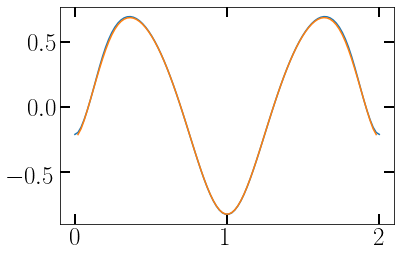

In [104]:
t=np.linspace(0,2,100)
flux=np.zeros(t.size)
rho=radian(5)
iota=radian(45)
alpha=radian(60)

for i in range(t.size):
  
    flux[i]=stokes(rho, iota, alpha, t[i])
    
plt.plot(t,flux)


t=np.linspace(0,2,100)
flux=np.zeros(t.size)
rho=radian(15)
iota=radian(45)
alpha=radian(60)

for i in range(t.size):

    flux[i]=stokes(rho, iota, alpha, t[i])

plt.plot(t,flux)

# Define the integration function 

In [106]:
from scipy.integrate import nquad
def t2T(theta_em):
    
    if theta_em<=pi/2:
        x=sin(theta_em)
        M=1.4*Ms
        R=10*km
        Rs=2*G*M/c**2
        ratio=Rs/R
        def integrand(u):
            return x * ((1-ratio)*(ratio/2)**2 -(1-2*u) * u**2 * x**2 ) ** (-0.5)
        sol=quad(integrand, 0, 0.5*ratio)
        return sol[0]
    else:
        return 2.30221254

def Ix(x):
    data=np.genfromtxt('./B143kev.dat')
    theta_em=data[:,0]
    Ix=data[:,1]
    Xmode= sp_interp1d(theta_em, Ix,fill_value=(Ix[0], 0),bounds_error=False)
    return Xmode(x)
    
def Io(x):
    data=np.genfromtxt('./B143kev.dat')
    theta_em=data[:,0]
    Io=data[:,2]
    Omode=sp_interp1d(theta_em, Io,fill_value=(Io[0], 0),bounds_error=False)
    return Omode(x)

# def t2T(theta_em):
    
#     xx1=np.linspace(0,pi/2,2000)
#     yy1=np.zeros(xx.size)
#     for i in range(xx1.size):
#         yy1[i]=raytracing(xx1[i])
#     te2th=sp_interp1d(xx1, yy1,fill_value=(0, raytracing(pi/2)),bounds_error=False)
#     return te2th(theta_em)

def T2t(theta_h):
    xx1=np.linspace(0,pi/2,2000)
    yy1=np.zeros(xx1.size)
    for i in range(xx1.size):
        yy1[i]=raytracing(xx1[i])
    th2te=sp_interp1d(yy1, xx1,fill_value=(0, pi/2),bounds_error=False)
    return th2te(theta_h)

def stokes(rho, iota, alpha, t):
    
    P=2
    omega=2*pi/P
    Phi=omega*t
    cosTheta=cos(iota)*cos(alpha)+sin(iota)*sin(alpha)*cos(Phi)
    Theta=np.arccos(cosTheta)
    Psi=np.arctan2(sin(alpha)*sin(Phi), (-sin(iota)*cos(alpha)+cos(iota)*sin(alpha)*cos(Phi)))
    
    phix=np.linspace(0,2*pi,500)
    b=np.zeros(500)
    b1=np.zeros(500)
    
#     for j in range(500):
        
#         def thetah(xx):
#             return cos(rho)-sin(xx) * sin(Theta)*cos(phix[j])-cos(xx)*cos(Theta)
    
#         b[j]=fsolve(thetah,0.4)[0]
#         b1[j]=T2t(b[j])
        
#     ss = sp_interp1d(phix,b1)
        
#     def phi2the(y1):
    
#         return ss(y1)
        
    
    if Theta==0:
        
        def integend1(x):
            
            return 2*pi*sin(x)*cos(x)*Ix(x)
        
        def integrand2(x):
            
            return 2*pi*sin(x)*cos(x)*Io(x)
        
        Fx=quad(integrand1, 0, T2t(rho))[0]
        Fo=quad(integrand2, 0, T2t(rho))[0]
        
    if Theta!=0 and rho<=Theta:
        
        def integrand1(x):
            
            return 2*np.arccos((cos(rho)-cos(Theta)*cos(t2T(x))) \
                               / (sin(Theta)*sin(t2T(x))))*sin(x)*cos(x)*Ix(x)
            
        def integrand2(x):
            
            return 2*np.arccos((cos(rho)-cos(Theta)*cos(t2T(x))) \
                               / (sin(Theta)*sin(t2T(x))))*sin(x)*cos(x)*Io(x)
        
        theta_h1=Theta-rho
        theta_h2=Theta+rho
        down=T2t(theta_h1)
        up=T2t(theta_h2)
        
        Fx=quad(integrand1, down, up)[0]
        Fo=quad(integrand2, down, up)[0]
       
    if Theta!=0 and rho>Theta:
        
        phi_h=np.linspace(0,2*pi,100)
        sol1=np.zeros(phi_h.size)
        sol2=np.zeros(phi_h.size)
        
        for i in range(phi_h.size): 
        
            def integrand1(x):
            
                return sin(x)*cos(x)*Ix(x)
            
            def integrand2(x):
            
                return sin(x)*cos(x)*Io(x)
        
            def thetah(xx):
                return cos(rho)-sin(xx) * sin(Theta)*cos(phi_h[i])-cos(xx)*cos(Theta)
            
            bound=T2t(fsolve(thetah,0.4)[0])
            print(bound)
            sol1[i]=quad(integrand1,0,bound)[0]
            sol2[i]=quad(integrand2,0,bound)[0]
        
            
        Fx = integrate.simpson(sol1, phi_h)

        Fo = integrate.simpson(sol2, phi_h)
            
    
    FI=Fx+Fo
    print(FI)

    FQ=(Fo-Fx)*cos(2*Psi)/FI

    FU=(Fo-Fx)*sin(2*Psi)/FI

    PL=(FQ**2+FU**2)**0.5/FI  
    
#     return FI,FQ,FU,PL
    return FQ
         

0.5949479830984897


<ipython-input-106-87056bc5b325>:130: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sol1[i]=quad(integrand1,0,bound)[0]
<ipython-input-106-87056bc5b325>:131: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose

0.5944024026854287
0.5927683074325959
0.5900536195642646
0.5862716383161303
0.5814412150876
0.5755869175930022
0.5687393012615631
0.5609350945966007
0.5522174729267958
0.5426362549099253
0.5322480315463499
0.5211161996390351
0.5093108655905878
0.49690858532644633
0.48399190852519863
0.4706486472995409


<ipython-input-106-87056bc5b325>:130: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sol1[i]=quad(integrand1,0,bound)[0]


0.4569709758513201
0.4430542543235196
0.428995580313762
0.4148922217430822
0.4008398725591095
0.3869308714488474
0.373252453612147
0.35988510548163943
0.34690122090190784
0.33436402550851946
0.3223268565238558
0.3108328725237232
0.29991515639065114
0.2895971427608233
0.27989337447025664
0.2708104525819478
0.2623481582724426
0.2545006012836037
0.2472574008193961
0.2406047973160841
0.2345266584029881
0.22900540076157322
0.2240227592333364
0.21956043776903825
0.21560066516923335
0.21212660742661937
0.20912270615516868
0.2065749523082517
0.20447106590099812


<ipython-input-106-87056bc5b325>:131: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sol2[i]=quad(integrand2,0,bound)[0]


0.20280064965950642
0.201555279654391
0.2007285934488872
0.20031632270058106
0.20031632270058106
0.2007285934488872
0.201555279654391
0.20280064965950642
0.20447106590099812
0.20657495230825154
0.20912270615516868
0.21212660742661937
0.2156006651692333
0.21956043776903825
0.2240227592333364
0.2290054007615731
0.2345266584029881
0.24060479731608417
0.2472574008193961
0.2545006012836037
0.26234815827244273
0.2708104525819478
0.27989337447025664
0.2895971427608233
0.29991515639065136
0.3108328725237232
0.3223268565238558
0.3343640255085196
0.34690122090190795
0.3598851054816395
0.3732524536121468
0.3869308714488475
0.4008398725591097
0.4148922217430822
0.4289955803137622
0.44305425432351975
0.4569709758513201
0.47064864729954076
0.4839919085251985
0.4969085853264464
0.5093108655905879
0.5211161996390351
0.5322480315463496
0.5426362549099252
0.5522174729267958
0.5609350945966008
0.5687393012615631
0.5755869175930023
0.5814412150876002
0.5862716383161303
0.5900536195642646
0.592768307432595

<ipython-input-106-87056bc5b325>:106: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fx=quad(integrand1, down, up)[0]
<ipython-input-106-87056bc5b325>:107: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose in

3358.055411665172


<ipython-input-106-87056bc5b325>:106: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Fx=quad(integrand1, down, up)[0]
<ipython-input-106-87056bc5b325>:107: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Fo=quad(integrand2, down, up)[0]


1777.6787357202047


<ipython-input-106-87056bc5b325>:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  sol=quad(integrand, 0, 0.5*ratio)


1100.1758320352637
1777.678735720208
3358.05541166517
0.5949479830984897
0.5944024026854287
0.5927683074325959
0.5900536195642646
0.5862716383161303
0.5814412150876
0.5755869175930022
0.5687393012615631
0.5609350945966007
0.5522174729267958
0.5426362549099253
0.5322480315463499
0.5211161996390351
0.5093108655905878
0.49690858532644633
0.48399190852519863
0.4706486472995409
0.4569709758513201
0.4430542543235196
0.428995580313762
0.4148922217430822
0.4008398725591095
0.3869308714488474
0.373252453612147
0.35988510548163943
0.34690122090190784
0.33436402550851946
0.3223268565238558
0.3108328725237232
0.29991515639065114
0.2895971427608233
0.27989337447025664
0.2708104525819478
0.2623481582724426
0.2545006012836037
0.2472574008193961
0.2406047973160841
0.2345266584029881
0.22900540076157322
0.2240227592333364
0.21956043776903825
0.21560066516923335
0.21212660742661937
0.20912270615516868
0.2065749523082517
0.20447106590099812
0.20280064965950642
0.201555279654391
0.2007285934488872
0.20031

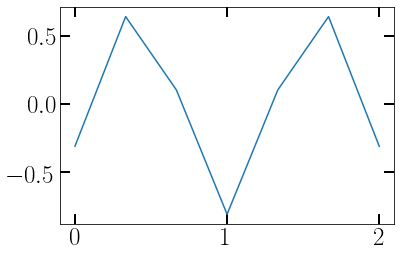

In [107]:
t=np.linspace(0,2,7)
flux=np.zeros(t.size)
rho=radian(30)
iota=radian(45)
alpha=radian(60)

for i in range(t.size):
  
    flux[i]=stokes(rho, iota, alpha, t[i])
    
plt.plot(t,flux)